In [7]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import torch.distributions as dists
import pandas as pd
from base_kan.ekan import EKAN 

In [ ]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = []

    def forward(self, t, y):
        S, I, R = y
        neural_output = self.neural_part(torch.tensor([S, I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy()) 
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt])

In [ ]:
gamma = 0.01
beta = 2 * gamma  
neural_ode_func = EKAN(layers_hidden=[2, 128, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

In [ ]:
intial = 0.  
last= 60.    
step = 60   
y0 = torch.tensor([0.99, 0.01, 0.0], requires_grad=True)  
t = torch.linspace(intial, last, step)  

In [12]:
def get_data():
    gamma = 0.01
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    a=0.2
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

In [13]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 2] - true_y[:, 2]) ** 2)

In [14]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 2] - true_y[:, 2])
    correct = (diff < threshold).float().mean()
    return correct.item()

In [ ]:
def forword_CF(x):
    
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    
    result = x.clone().detach()
    

    result[1:] = x[1:] - x[:-1]
    
    return result

In [16]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(3000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

In [17]:
t, True_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.0018770567839965224, Accuracy: 50.00%
Iter 100, Loss: 4.117363641853444e-05, Accuracy: 96.67%
Iter 200, Loss: 3.832494257949293e-06, Accuracy: 100.00%
Iter 300, Loss: 2.8795441266993294e-06, Accuracy: 100.00%
Iter 400, Loss: 2.1106018266436877e-06, Accuracy: 100.00%
Iter 500, Loss: 1.5251829381668358e-06, Accuracy: 100.00%
Iter 600, Loss: 1.0887233656831086e-06, Accuracy: 100.00%
Iter 700, Loss: 7.691089081163227e-07, Accuracy: 100.00%
Iter 800, Loss: 5.396552751335548e-07, Accuracy: 100.00%
Iter 900, Loss: 3.7785258655276266e-07, Accuracy: 100.00%
Iter 1000, Loss: 2.6595813551466563e-07, Accuracy: 100.00%
Iter 1100, Loss: 1.9012054508493748e-07, Accuracy: 100.00%
Iter 1200, Loss: 1.395250990299246e-07, Accuracy: 100.00%
Iter 1300, Loss: 1.0653788962144972e-07, Accuracy: 100.00%
Iter 1400, Loss: 8.526584593937514e-08, Accuracy: 100.00%
Iter 1500, Loss: 7.164664594938586e-08, Accuracy: 100.00%
Iter 1600, Loss: 6.283822528985183e-08, Accuracy: 100.00%
Iter 1700, Loss: 5.7

In [18]:
True_y[:,2] = forword_CF(True_y[:,2])
pred_y[:,2] = forword_CF(pred_y[:,2])

/tmp/ipykernel_2955414/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [ ]:

extend = 60
timeintial = intial
timeend = last + extend
timestep = step + extend
in_t = torch.linspace(timeintial, timeend, timestep)

In [21]:
def get_data():
    gamma = 0.01
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    a=0.2
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        in_true_y = odeint(sir, true_y0, in_t, rtol=1e-5, atol=1e-8)
    return in_t, in_true_y

in_t, in_true_y = get_data()

In [22]:
with torch.no_grad():
    in_pred_y = odeint(model, y0, in_t, rtol=1e-5, atol=1e-8)

In [23]:
in_true_y[:,2] = forword_CF(in_true_y[:,2])
in_pred_y[:,2] = forword_CF(in_pred_y[:,2])

/tmp/ipykernel_2955414/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [24]:
tdata = {
    'Time': t.numpy(),
    'True_S': True_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': True_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': True_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],

}

idata = {
    'Time': in_t.numpy(),
    'in_true_S': in_true_y.numpy()[:, 0],
    'in_Predicted_S': in_pred_y.detach().numpy()[:, 0],
    'in_true_I': in_true_y.numpy()[:, 1],
    'in_Predicted_I': in_pred_y.detach().numpy()[:, 1],
    'in_true_R': in_true_y.numpy()[:, 2],
    'in_Predicted_R': in_pred_y.detach().numpy()[:, 2],

}
dft = pd.DataFrame(tdata)
dfi = pd.DataFrame(idata)

In [25]:
dfi.to_excel('ZS-ti.xlsx', index=False)

In [26]:
def get_data():
    gamma = 0.01
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    a=0.2
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, y = get_data()

In [ ]:

y = y * 10000

poisson_dist = dists.Poisson(y)

poisson_noise = poisson_dist.sample()
true_y = poisson_noise/10000
y = y/10000

In [29]:
t, Z_true_y, Z_pred_y, Z_neural_outputs = train()

Iter 0, Loss: 7.361027201113757e-06, Accuracy: 100.00%
Iter 100, Loss: 6.097453479014803e-06, Accuracy: 100.00%
Iter 200, Loss: 5.668471658282215e-06, Accuracy: 100.00%
Iter 300, Loss: 5.6019166549958754e-06, Accuracy: 100.00%
Iter 400, Loss: 5.532313025469193e-06, Accuracy: 100.00%
Iter 500, Loss: 5.460687134473119e-06, Accuracy: 100.00%
Iter 600, Loss: 5.3893663789494894e-06, Accuracy: 100.00%
Iter 700, Loss: 5.322063316270942e-06, Accuracy: 100.00%
Iter 800, Loss: 5.259445970295928e-06, Accuracy: 100.00%
Iter 900, Loss: 5.202510692470241e-06, Accuracy: 100.00%
Iter 1000, Loss: 5.151630830368958e-06, Accuracy: 100.00%
Iter 1100, Loss: 5.107953256811015e-06, Accuracy: 100.00%
Iter 1200, Loss: 5.070457518741023e-06, Accuracy: 100.00%
Iter 1300, Loss: 5.0390008254908025e-06, Accuracy: 100.00%
Iter 1400, Loss: 5.013035206502536e-06, Accuracy: 100.00%
Iter 1500, Loss: 4.991914011043264e-06, Accuracy: 100.00%
Iter 1600, Loss: 4.974777311872458e-06, Accuracy: 100.00%
Iter 1700, Loss: 4.9639

In [ ]:

y = True_y[:,2] * 10000

poisson_dist = dists.Poisson(y)

poisson_noise = poisson_dist.sample()
Z_true_y[:,2] = poisson_noise/10000

In [31]:
Z_pred_y[:,2] = forword_CF(Z_pred_y[:,2])

/tmp/ipykernel_2955414/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [ ]:

extend = 60
timeintial = intial
timeend = last + extend
timestep = step + extend
in_t = torch.linspace(timeintial, timeend, timestep)

In [33]:
with torch.no_grad():
    Z_in_pred_y = odeint(model, y0, in_t, rtol=1e-5, atol=1e-8)

In [34]:
Z_in_pred_y[:,2] = forword_CF(Z_in_pred_y[:,2])

/tmp/ipykernel_2955414/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [35]:
tdata = {
    'Time': t.numpy(),
    'True_S': Z_true_y.numpy()[:, 0],
    'Predicted_S': Z_pred_y.detach().numpy()[:, 0],
    'True_I': Z_true_y.numpy()[:, 1],
    'Predicted_I': Z_pred_y.detach().numpy()[:, 1],
    'True_R': Z_true_y.numpy()[:, 2],
    'Predicted_R': Z_pred_y.detach().numpy()[:, 2],
}

idata = {   
    'Time': in_t.numpy(),
    'Z_in_pred_S': Z_in_pred_y.detach().numpy()[:, 0],
    'Z_in_pred_I': Z_in_pred_y.detach().numpy()[:, 1],
    'Z_in_pred_R': Z_in_pred_y.detach().numpy()[:, 2],
}
dft = pd.DataFrame(tdata)
dfi = pd.DataFrame(idata)


In [36]:
dfi.to_excel('ZS-zti.xlsx', index=False)
dft.to_excel('ZS-ti-z.xlsx', index=False)

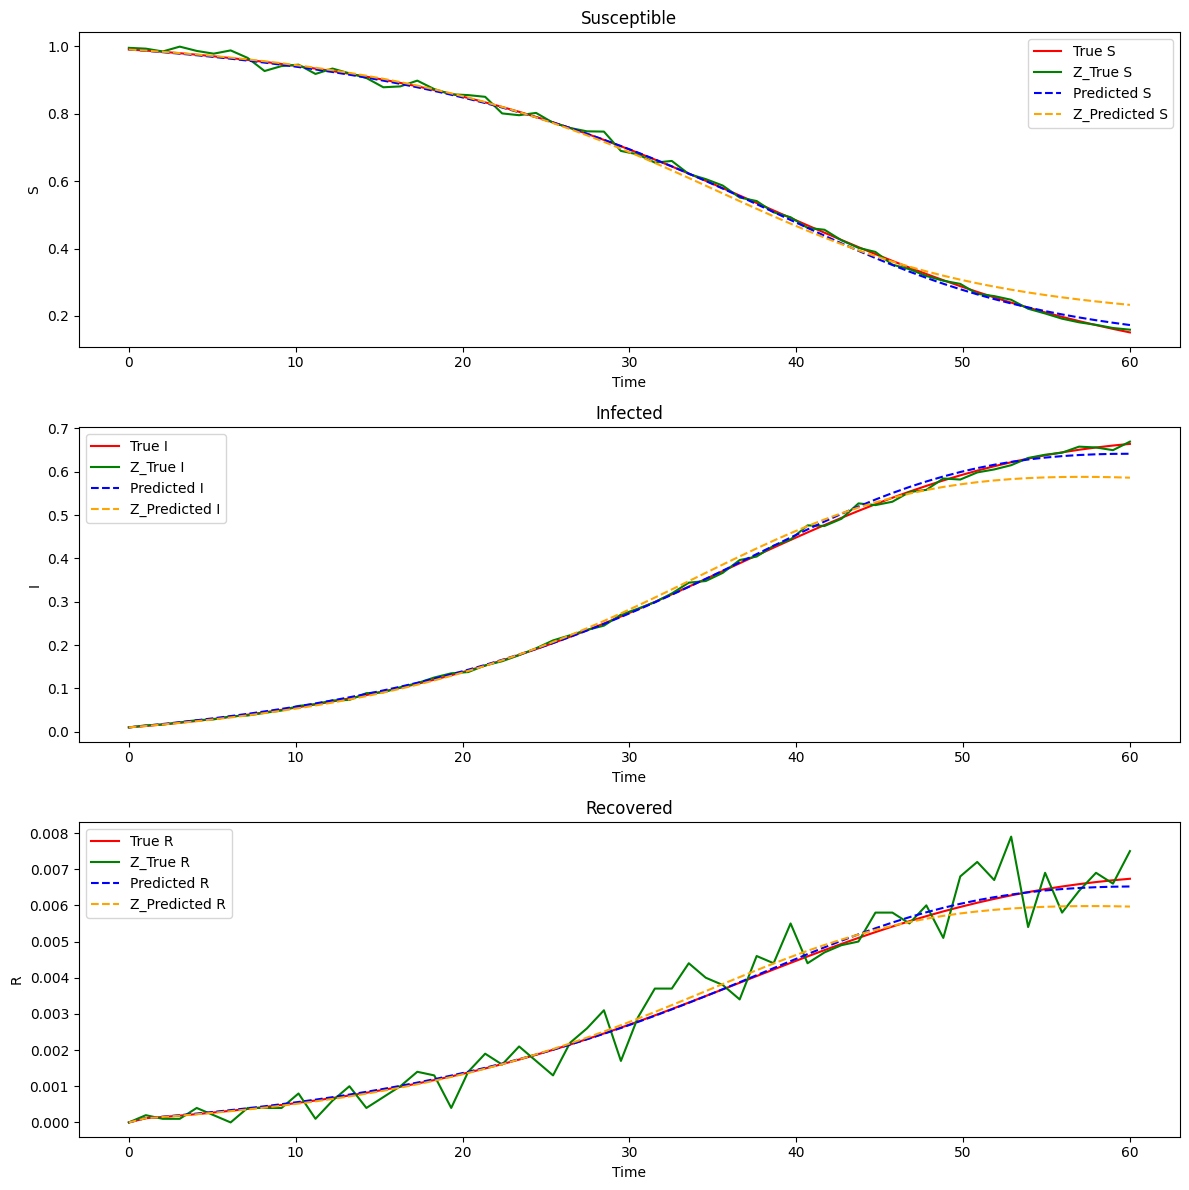

In [37]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), True_y.numpy()[:, 0], '-', label='True S', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 0], '-', label='Z_True S', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], '--', label='Predicted S', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 0], '--', label='Z_Predicted S', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), True_y.numpy()[:, 1], '-', label='True I', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 1], '-', label='Z_True I', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], '--', label='Predicted I', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 1], '--', label='Z_Predicted I', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), True_y.numpy()[:, 2], '-', label='True R', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 2], '-', label='Z_True R', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], '--', label='Predicted R', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 2], '--', label='Z_Predicted R', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')


plt.tight_layout()
plt.show()


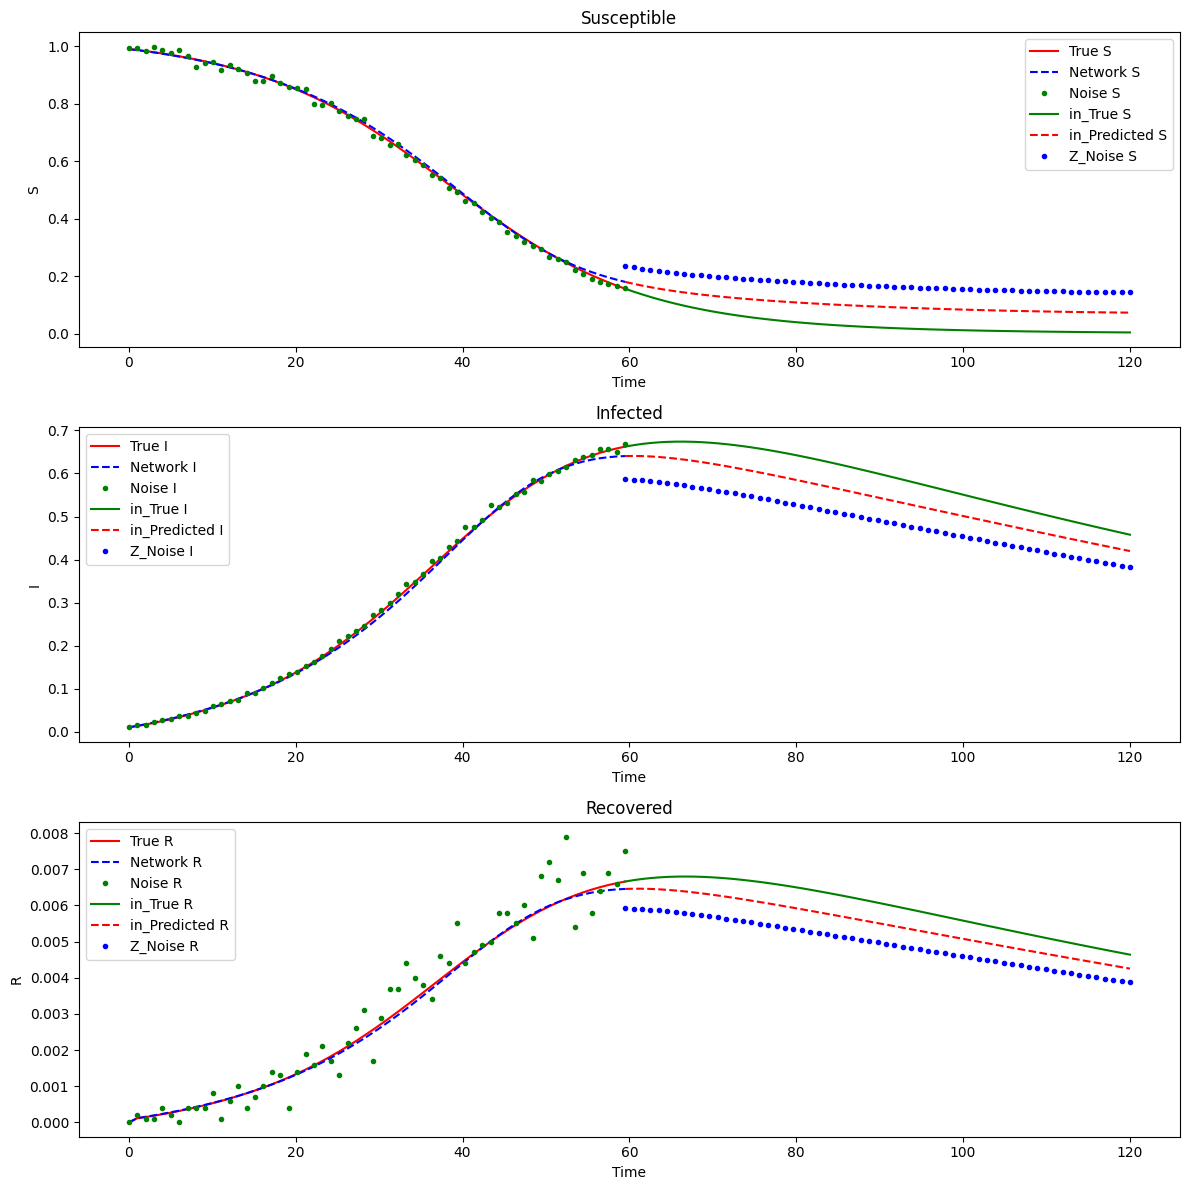

In [38]:
last = int(last)
timeend = int(timeend)
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 0], '-', label='True S', color='red')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 0], '--', label='Network S', color='blue')
plt.plot(in_t.numpy()[:last], Z_true_y.detach().numpy()[:last, 0], '.', label='Noise S', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 0], '-', label='in_True S', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 0], '--', label='in_Predicted S',color='red')
plt.plot(in_t.numpy()[last-1:timeend], Z_in_pred_y.detach().numpy()[last-1:timeend, 0], '.', label='Z_Noise S', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 1], '-', label='True I', color='red')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 1], '--', label='Network I', color='blue')
plt.plot(in_t.numpy()[:last], Z_true_y.detach().numpy()[:last, 1], '.', label='Noise I', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 1], '-', label='in_True I', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 1], '--', label='in_Predicted I',color='red')
plt.plot(in_t.numpy()[last-1:timeend], Z_in_pred_y.detach().numpy()[last-1:timeend, 1], '.', label='Z_Noise I', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 2], '-', label='True R', color='red')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 2], '--', label='Network R', color='blue')
plt.plot(in_t.numpy()[:last], Z_true_y.detach().numpy()[:last, 2], '.', label='Noise R', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 2], '-', label='in_True R', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 2], '--', label='in_Predicted R',color='red')
plt.plot(in_t.numpy()[last-1:timeend], Z_in_pred_y.detach().numpy()[last-1:timeend, 2], '.', label='Z_Noise R', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.show()